The main purpose of this project is to shed light to the biggest refuge crisis in history over time by story telling with visualization.

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import *

In [4]:
unhcr = list(Path('data/UNHCR/refugee-data/').iterdir())

In [5]:
unhcr

[PosixPath('data/UNHCR/refugee-data/asylum_seekers_monthly.csv'),
 PosixPath('data/UNHCR/refugee-data/resettlement.csv'),
 PosixPath('data/UNHCR/refugee-data/demographics.csv'),
 PosixPath('data/UNHCR/refugee-data/time_series.csv'),
 PosixPath('data/UNHCR/refugee-data/asylum_seekers.csv'),
 PosixPath('data/UNHCR/refugee-data/persons_of_concern.csv')]

### Data Preprocess


Origin: Syria

Year > 2010

In [15]:
asylum_seekers_monthly = pd.read_csv(unhcr[0])
resettlement = pd.read_csv(unhcr[1])
demographics = pd.read_csv(unhcr[2])
time_series = pd.read_csv(unhcr[3])
asylum_seekers = pd.read_csv(unhcr[4])
persons_of_concern = pd.read_csv(unhcr[5])

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3,4,5,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# What is trend ? Where is to trend ?
asylum_seekers_monthly.head(2)

,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Australia,Afghanistan,1999,January,8
1,Australia,Afghanistan,1999,February,10


In [16]:
# Resettlement is the transfer of refugees from an asylum country 
# to another State that has agreed to admit them and ultimately grant them permanent settlement. 
# Who helps for good ?
resettlement.head(2)

,Country / territory of asylum/residence,Origin,Year,Value
0,Canada,Albania,1959,17
1,Canada,Austria,1959,17


In [22]:
# yearly flow of type of population
time_series.head(2)

,Year,Country / territory of asylum/residence,Origin,Population type,Value
0,1951,Australia,Various/Unknown,Refugees (incl. refugee-like situations),180000
1,1951,Austria,Various/Unknown,Refugees (incl. refugee-like situations),282000


In [24]:
time_series['Population type'].unique()

array(['Refugees (incl. refugee-like situations)', 'Returnees',
       'Internally displaced persons', 'Returned IDPs',
       'Others of concern', 'Asylum-seekers', 'Stateless'], dtype=object)

In [17]:
# refugee demographics by countries
# Who is affected the most ?
demographics.head(2)

,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,Kabul,0,NaN,1.0,NaN,1,0,0.0,2,0,NaN,0.0,NaN,2,0,0.0,2
1,2001,Afghanistan,Various,14335,NaN,45451.0,NaN,99880,19234,412004.0,590904,14716,NaN,47522.0,NaN,114965,13025,435492.0,625720


In [20]:
# Who helps the most ? To whom people ask help ? What helps the most ?
asylum_seekers.head(2)

,Year,Country / territory of asylum/residence,Origin,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year)
0,2000,Zimbabwe,Afghanistan,G / FI,0,0,5,5,0,0,0,5,0,0
1,2000,South Africa,Afghanistan,G / FI,8,1,0,0,0,0,0,NaN,8,0


In [23]:
# pivot format of time_series
persons_of_concern.head(2)

,Year,Country / territory of asylum/residence,Origin,Refugees (incl. refugee-like situations),Asylum-seekers (pending cases),Returned refugees,Internally displaced persons (IDPs),Returned IDPs,Stateless persons,Others of concern,Total Population
0,1951,Australia,Various/Unknown,180000,NaN,NaN,NaN,NaN,NaN,NaN,180000
1,1951,Austria,Various/Unknown,282000,NaN,NaN,NaN,NaN,NaN,NaN,282000


### Filter Data

In [27]:
def filter_data(data):
    if 'Origin' in data.columns:
        data = data[(data.Year > 2010) & (data.Origin.str.contains('Syria'))]
    else:
        data = data[(data.Year > 2010)]
    return data

In [28]:
asylum_seekers_monthly = filter_data(asylum_seekers_monthly)
resettlement = filter_data(resettlement)
time_series = filter_data(time_series)
demographics = filter_data(demographics)
asylum_seekers = filter_data(asylum_seekers)
persons_of_concern = filter_data(persons_of_concern)

### Correct Data Types

In [65]:
asylum_seekers_monthly.dtypes

Country / territory of asylum/residence    object
Origin                                     object
Year                                        int64
Month                                      object
Value                                      object
dtype: object

In [104]:
def str2num(data):
    """
    For each object type column check if any entry starts and
    ends with a digit. Replace * with np.nan since it's
    noted * is used to mask confidential information.
    Convert those columns to float type.
    """
    columns = data.select_dtypes(['object']).columns
    for c in columns:
        if data[c].str.contains('^\d*$', regex=True).any():
            print(f'Converting column : {c}')
            data[c] = data[c].replace('*', np.nan).astype(np.float)
    return data

In [108]:
str2num(persons_of_concern)

,Year,Country / territory of asylum/residence,Origin,Refugees (incl. refugee-like situations),Asylum-seekers (pending cases),Returned refugees,Internally displaced persons (IDPs),Returned IDPs,Stateless persons,Others of concern,Total Population
78304,2011,United Arab Emirates,Syrian Arab Rep.,37.0,6.0,NaN,NaN,NaN,NaN,NaN,43.0
78405,2011,Armenia,Syrian Arab Rep.,6.0,2.0,NaN,NaN,NaN,NaN,NaN,8.0
78517,2011,Australia,Syrian Arab Rep.,84.0,66.0,NaN,NaN,NaN,NaN,NaN,150.0
78634,2011,Austria,Syrian Arab Rep.,903.0,456.0,NaN,NaN,NaN,NaN,NaN,1359.0
78665,2011,Azerbaijan,Syrian Arab Rep.,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
78781,2011,Belgium,Syrian Arab Rep.,312.0,666.0,NaN,NaN,NaN,NaN,NaN,978.0
78824,2011,Benin,Syrian Arab Rep.,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
78909,2011,Bulgaria,Syrian Arab Rep.,98.0,70.0,NaN,NaN,NaN,NaN,NaN,168.0
78928,2011,Bahrain,Syrian Arab Rep.,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0
78953,2011,Bosnia and Herzegovina,Syrian Arab Rep.,1.0,2.0,NaN,NaN,NaN,NaN,NaN,3.0


### Save new data

In [109]:
unhcr

[PosixPath('data/UNHCR/refugee-data/asylum_seekers_monthly.csv'),
 PosixPath('data/UNHCR/refugee-data/resettlement.csv'),
 PosixPath('data/UNHCR/refugee-data/demographics.csv'),
 PosixPath('data/UNHCR/refugee-data/time_series.csv'),
 PosixPath('data/UNHCR/refugee-data/asylum_seekers.csv'),
 PosixPath('data/UNHCR/refugee-data/persons_of_concern.csv')]

In [118]:
asylum_seekers_monthly = (asylum_seekers_monthly).to_csv(unhcr[0], index=False)
resettlement = (resettlement).to_csv(unhcr[1], index=False)
time_series = (time_series).to_csv(unhcr[2], index=False)
demographics = (demographics).to_csv(unhcr[3], index=False)
asylum_seekers = (asylum_seekers).to_csv(unhcr[4], index=False)
persons_of_concern = (persons_of_concern).to_csv(unhcr[5], index=False)

### Basic EDA

In [119]:
asylum_seekers_monthly = pd.read_csv(unhcr[0])
resettlement = pd.read_csv(unhcr[1])
demographics = pd.read_csv(unhcr[2])
time_series = pd.read_csv(unhcr[3])
asylum_seekers = pd.read_csv(unhcr[4])
persons_of_concern = pd.read_csv(unhcr[5])

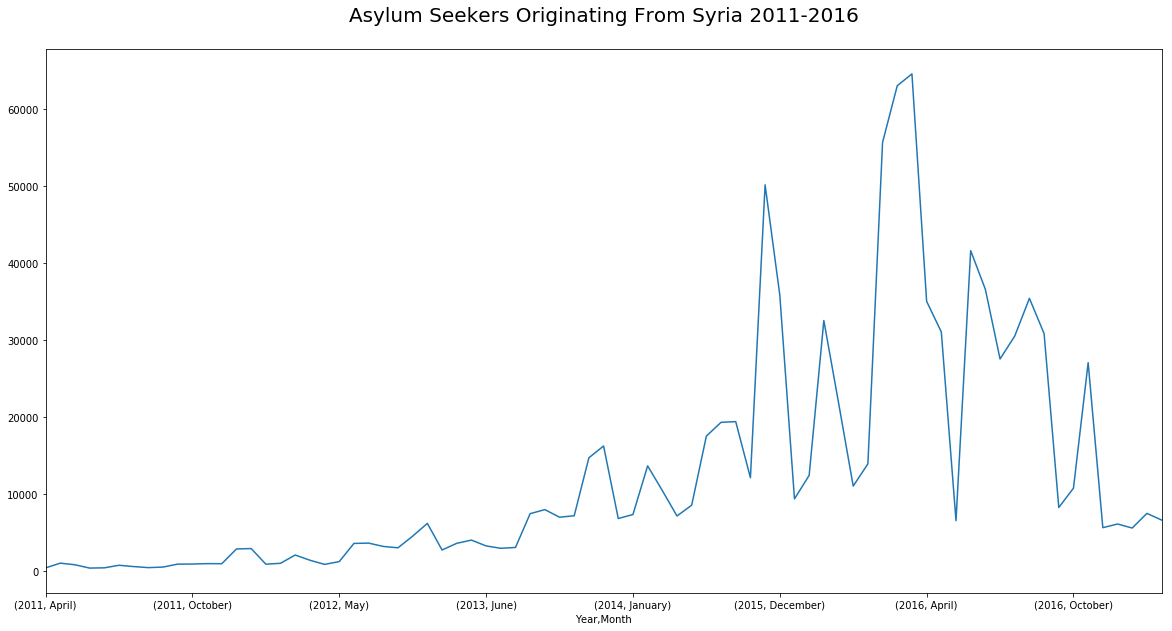

In [139]:
plt.figure(figsize=(20,10))
plt.title('Asylum Seekers Originating From Syria 2011-2016\n', fontdict={'fontsize':20})
ax = asylum_seekers_monthly.groupby(['Year', 'Month'])['Value'].sum().plot()

### Causalities of Civil War

Process data

In [148]:
causalities = pd.read_csv('./data/civil_war_causalities.csv', encoding="ISO-8859-1")

In [154]:
causalities.dtypes

name          object
status        object
gender        object
province      object
birthPlace    object
deathDate     object
deathCause    object
actor         object
dtype: object

In [155]:
causalities.head(2)

,name,status,gender,province,birthPlace,deathDate,deathCause,actor
0,Abo Yazan al-Jbailia,Non-Civilian,Adult - Male,Daraa,Jbailieh,2018-04-13,Explosion,Not identified
1,Maher Mohammad al-Ezo al-Shami,Civilian,Child - Male,Hama,Huribnefseh,2018-04-13,Shelling,Syrian government and affiliated militias


In [156]:
causalities.deathCause.unique()

array(['Explosion', 'Shelling', 'Shooting', 'Warplane shelling',
       'Field Execution', 'Chemical and toxic gases',
       'Detention - Torture', 'Kidnapping - Execution', 'Other',
       'Unknown', 'Un-allowed to seek Medical help', 'Siege',
       'Detention - Execution', 'Kidnapping - Torture',
       'Kidnapping - Torture - Execution',
       'Detention - Torture - Execution', nan], dtype=object)

In [152]:
causalities.groupby('actor').count()

,name,status,gender,province,birthPlace,deathDate,deathCause
actor,,,,,,,
Al-Nusra Front,221,221,221,221,174,221,221
Armed opposition groups,1914,1915,1915,1915,1616,1915,1915
International coalition forces,2190,2191,2191,2191,1793,2191,2191
Not identified,3462,3464,3464,3464,3067,3464,3464
Russian troops,3871,3873,3873,3873,3577,3873,3873
Self administration forces,599,599,599,599,489,599,599
Syrian government and affiliated militias,20603,20613,20613,20613,19262,20608,20613
The organization of the Islamic State in Iraq and the Levant - ISIS,6718,6720,6720,6720,5647,6720,6720


In [153]:
causalities.groupby(['actor', 'gender']).count()

name  \
actor                                              gender                  
Al-Nusra Front                                     Adult - Female      6   
                                                   Adult - Male      212   
                                                   Child - Male        3   
Armed opposition groups                            Adult - Female    150   
                                                   Adult - Male     1548   
                                                   Child - Female     68   
                                                   Child - Male      148   
International coalition forces                     Adult - Female    343   
                                                   Adult - Male     1363   
                                                   Child - Female    188   
                                                   Child - Male      296   
Not identified                                     Adult - Female    332   
                                                   Adult - Male     2680   
                                                   Child - Female    142   
                                                   Child - Male      308   
Russian troops                                     Adult - Female    596   
                                                   Adult - Male     2312   
                                                   Child - Female    409   
                                                   Child - Male      554   
Self administration forces                         Adult - Female     32   
                                                   Adult - Male      517   
                                                   Child - Female     19   
                                                   Child - Male       31   
Syrian government and affiliated militias          Adult - Female   1887   
                                                   Adult - Male    15536   
                                                   Child - Female   1096   
                                                   Child - Male     2084   
The organization of the Islamic State in Iraq a... Adult - Female    314   
                                                   Adult - Male     5987   
                                                   Child - Female     90   
                                                   Child - Male      327   

                                                                   status  \
actor                                              gender                   
Al-Nusra Front                                     Adult - Female       6   
                                                   Adult - Male       212   
                                                   Child - Male         3   
Armed opposition groups                            Adult - Female     150   
                                                   Adult - Male      1549   
                                                   Child - Female      68   
                                                   Child - Male       148   
International coalition forces                     Adult - Female     343   
                                                   Adult - Male      1363   
                                                   Child - Female     188   
                                                   Child - Male       297   
Not identified                                     Adult - Female     332   
                                                   Adult - Male      2680   
                                                   Child - Female     143   
                                                   Child - Male       309   
Russian troops                                     Adult - Female     597   
                                                   Adult - Male      2313   
                                                   Child - Female     409   
                   

In [150]:
causalities.groupby(['status', 'gender']).count()

name  province  birthPlace  deathDate  \
status       gender                                                    
Civilian     Adult - Female   16927     16931       15988      16930   
             Adult - Male    107974    108009       98628     107997   
             Child - Female    8733      8735        8335       8730   
             Child - Male     17583     17588       16603      17587   
Non-Civilian Adult - Female      30        30          30         30   
             Adult - Male     60151     60164       52812      60155   
             Child - Female       2         2           2          2   
             Child - Male       448       448         405        448   

                             deathCause  actor  
status       gender                             
Civilian     Adult - Female       16931   3642  
             Adult - Male        108009  17791  
             Child - Female        8735   2011  
             Child - Male         17588   3688  
Non-Civilian Adult - Female          30     20  
             Adult - Male         60164  12376  
             Child - Female           2      2  
             Child - Male           448     66